Preprocessing:
    
    - Timestamp, merging dataframes
    - Handling the missing data   
    - Feature scaling
    - Feature encoding
    
Modeling:

    - Train,test,split, kfold
    - Linear Regression
    - column transformer
    - Pipeline
    
Evaluation:

    - Evaluation metrics
    - Visualization
    


In [5]:
####################################################
## Getting the data

from influxdb import InfluxDBClient # install via "pip install influxdb"
import pandas as pd

client = InfluxDBClient(host='influxus.itu.dk', port=8086, username='lsda', password='icanonlyread')
client.switch_database('orkney')


def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index
    return df

# Get the last 90 days of power generation data
generation = client.query(
    "SELECT * FROM Generation where time > now()-90d"
    ) # Query written in InfluxQL

# Get the last 90 days of weather forecasts with the shortest lead time
wind  = client.query(
    "SELECT * FROM MetForecasts where time > now()-90d and time <= now() and Lead_hours = '1'"
    ) # Query written in InfluxQL


gen_df = get_df(generation)
wind_df = get_df(wind)


## Aligning the timestamps
gen_df has 1 value for each min, yet wind_df has a value for each 3h

In [6]:
gen_df = pd.DataFrame(gen_df['Total'])
print(f"Before resampling: {gen_df.shape}")
gen_df = gen_df.resample('3h').mean()
print(f"After resampling: {gen_df.shape}")
gen_df.head()

Before resampling: (129446, 1)
After resampling: (721, 1)


,Total
time,
2022-06-09 15:00:00+00:00,22.515168
2022-06-09 18:00:00+00:00,23.381639
2022-06-09 21:00:00+00:00,16.340972
2022-06-10 00:00:00+00:00,10.932711
2022-06-10 03:00:00+00:00,9.970450


In [7]:
wind_df = wind_df['Speed']

############################ Concatenating the dataframes ############################
main_df = pd.concat([wind_df, gen_df], axis=1)
print(f"Null values:\n {main_df.isnull().sum()}")

Null values:
 Speed    45
Total     0
dtype: int64


## Dropping the null values

In [8]:
main_df = main_df.dropna()
main_df.isnull().sum()

Speed    0
Total    0
dtype: int64

## SimpleImputer

In [9]:
# from sklearn.impute import SimpleImputer
# import numpy as np

# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# main_df = pd.DataFrame(imp_mean.fit_transform(main_df), columns=[['Speed', 'Total']])
# main_df.isnull().sum()

In [10]:
main_df.head()

,Speed,Total
time,,
2022-06-09 18:00:00+00:00,8.94080,23.381639
2022-06-09 21:00:00+00:00,8.94080,16.340972
2022-06-10 00:00:00+00:00,5.81152,10.932711
2022-06-10 03:00:00+00:00,4.02336,9.970450
2022-06-10 06:00:00+00:00,5.81152,17.648395


In [11]:
from sklearn.model_selection import train_test_split

X = main_df['Speed']
y = main_df['Total']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [12]:
print(f"Shape of x_train: {x_train.shape}, Shape of x_test: {x_test.shape}") 

Shape of x_train: (540,), Shape of x_test: (136,)


In [13]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

x_train = np.array(x_train).reshape(-1,1)
y_train = np.array(y_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)

reg = LinearRegression().fit(x_train, y_train)
print(f"Score: {round(reg.score(x_train, y_train),2)}")
y_pred = reg.predict(x_test)

Score: 0.62


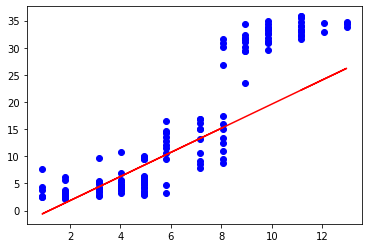

In [14]:
plt.scatter(x_test,y_test, color='b')
plt.plot(x_test, y_pred, color='r')
plt.show()

In [15]:
# mx + b
num = 3
x = x_test[num]
m = reg.coef_[0][0]
b = reg.intercept_
print(f"\tmx + b = y{m * x + b}")
print(f"\tpredicted:{y_pred[num]}")

	mx + b = y[17.26108943]
	predicted:[17.26108943]


## Metrics evaluation

In [16]:
from sklearn.metrics import mean_squared_error as mse

print(f"\tMean Square Error: {round(mse(x_test, y_pred),2)}")
print(f"\tRoot Mean Square Error: {round(mse(x_test, y_pred, squared=False),2)}")

	Mean Square Error: 41.92
	Root Mean Square Error: 6.47


# Save the dataframes

In [17]:
main_df.to_csv('Data.csv')

# Load the dataframes

In [18]:
df = pd.read_csv('Data.csv')

## Costum transformer

In [19]:
# basic example
# creating the transformer first
from sklearn.base import TransformerMixin, BaseEstimator
class my_basic_transformer(TransformerMixin, BaseEstimator):
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x, y=None):
        transformed = x * 5 ############################## transform action takes place ##############################
        return transformed
    
# testing the transformer
# here I make an example
x_train = pd.DataFrame(np.array([[1, 1], [1, 2], [2, 2], [2, 3]]), columns=['col1', 'col2'])
y_train = np.dot(x_train, np.array([1, 2])) + 3 ############## no need atm ##############
x_test = pd.DataFrame(np.array([[3, 5]]), columns=['col1', 'col2']) ############## no need atm ############## 

# instantiating 
test = my_basic_transformer()

# transforming
test.fit_transform(x_train)

,col1,col2
0,5,5
1,5,10
2,10,10
3,10,15


## Column transformer from sklearn

Perform the preprocessing here.
Feature scaling is added here as well.

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler # check the documents what it does
ct = ColumnTransformer([
    ('my_basic_transformer', test, ['col1', 'col2']), # if dataframe is passed you need to specify what column should be transformed.
    ('mms', MinMaxScaler(), ['col1', 'col2'])  
])

ct.fit_transform(x_train)

array([[ 5. ,  5. ,  0. ,  0. ],
       [ 5. , 10. ,  0. ,  0.5],
       [10. , 10. ,  1. ,  0.5],
       [10. , 15. ,  1. ,  1. ]])

## Pipeline from sklearn
Pass your column transformer and model in the pipeline

In [21]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('my_ct', ct),
    ('lr', LinearRegression())
])

# we created y_train, x_test earlier. 
pipeline.fit(x_train, y_train)
pipeline.predict(x_test)

array([16.])

## More costum transformer example
dont forget to install dateutil with "pip install dateutils"

In [22]:
from dateutil import parser

class DateParser(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        X["Time"] = [ parser.parse(d, ignoretz=True) for d in X["Time"].values ]
        return X

class WeekendAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X["business_day"] = [ int(np.is_busday(d)) for d in X["Time"].values.astype('M8[D]') ]
        return X

class HourAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X["hour"] = [ pd.to_datetime(d).hour for d in X["Time"].values ]
        return X

class DropTime(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop("Time",axis=1)

## Feature encoding

In [23]:
######################################## fetching the data again ########################################
generation = client.query(
    "SELECT * FROM Generation where time > now()-90d"
    ) # Query written in InfluxQL

# Get the last 90 days of weather forecasts with the shortest lead time
wind  = client.query(
    "SELECT * FROM MetForecasts where time > now()-90d and time <= now() and Lead_hours = '1'"
    ) # Query written in InfluxQL


gen_df = get_df(generation)
wind_df = get_df(wind)

gen_df = pd.DataFrame(gen_df['Total'])
wind_df = wind_df[["Direction", "Speed"]]

In [24]:
wind_df.head()

,Direction,Speed
time,,
2022-06-09 18:00:00+00:00,SE,8.94080
2022-06-09 21:00:00+00:00,SE,8.94080
2022-06-10 00:00:00+00:00,S,5.81152
2022-06-10 03:00:00+00:00,S,4.02336
2022-06-10 06:00:00+00:00,SSE,5.81152


In [26]:
from sklearn.preprocessing import OneHotEncoder

splitter = ColumnTransformer([
    ("MinMaxScaler", MinMaxScaler(), ['Speed']),
    ("OneHotEncoder", OneHotEncoder(), ['Direction']),
])

pd.DataFrame(np.array(splitter.fit_transform(wind_df).todense()), columns=["Speed", "Direction1","Direction2","Direction3",
                                                                           "Direction4","Direction5","Direction6", "Direction7",
                                                                           "Direction8","Direction9","Direction10", "Direction11",
                                                                           "Direction12","Direction13","Direction14", "Direction15",
                                                                           "Direction16"
                                                                          ])

,Speed,Direction1,Direction2,Direction3,Direction4,Direction5,Direction6,Direction7,Direction8,Direction9,Direction10,Direction11,Direction12,Direction13,Direction14,Direction15,Direction16
0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.305556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.194444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.305556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,0.750000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
672,0.750000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
673,0.694444,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674,0.638889,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
